In [ ]:
# TODO: put all vis at the end, fix pipeline

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import re
import random

from utils.analysis_utils import *

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

%matplotlib inline

In [2]:
dfs = glob.glob('data/dataframes/*.p')

In [3]:
# This is done to ensure that the class dataframes are read in chronological order, not by the order 
# by which they appear within the file system.

id_class_map = {}
id_class_map['iqv0bsb3p2i3ch'] = 'Fall 2016 Dewan'
id_class_map['j5wwaj87hvu6af'] = 'Fall 2017 KMP'
id_class_map['jz8ejj1lawb5st'] = 'Fall 2018 Dewan'
id_class_map['jqnyuvgzug4p3'] = 'Spring 2019 KMP'
id_class_map['jkws0l0gvcr7it'] = 'Fall 2019 KMP'

ordered_dfs = [] 
for i in id_class_map:
    for df in dfs:
        if i in df:
            ordered_dfs.append(df)
            
dfs = ordered_dfs

# Get the Piazza network id of each course
network_ids = [re.search(r'dataframe_(.*?)\.p', file_path).group(1) for file_path in dfs]

In [4]:
student_dfs = [] # The un-pickled posts for each 401 Class (student posts)
instructor_dfs = [] # The un-pickled posts for each 401 Class (instructor posts)
lda_output = [] # The output of every LDA model 
all_topic_words = [] # All of the top_n topics for each LDA model 

# Run LDA on the text of every 401 class' posts
for i in range(len(dfs)):
    # Read in the dataframe and only select student posts
    current_df = pd.read_pickle(dfs[i])
        
    # Adding on new features 
    current_df['word_count'] = current_df['text'].map(lambda x: len(x))   
    
    student_df = current_df.query("is_student")
    instructor_df = current_df.query("is_student==False")
        
    student_dfs.append(student_df)
    instructor_dfs.append(instructor_df)
    
    data_list = current_df["text"].tolist()
    lda_output.append(lda_operation(data_list))
    
# Save all of the words found by the topic model for each class
for output in lda_output:
    print_topics(*output)
    all_topic_words.append(save_topics(*output))
    
### Takeways 

# Topic models are mostly java keywords and administrative questions. 

# How can we improve this?

Topic 0:
[('object', 473.245826992338), ('method', 473.06988484976887), ('public', 433.8483760124484), ('avatar', 78.17749343190209), ('java', 67.36342224356085), ('string', 66.7609407612646), ('class', 55.61240920126569), ('bridgescene', 33.97343062801197), ('command', 24.778752607343893), ('say', 19.168774769040773)]
Topic 1:
[('assignment', 116.36858741999418), ('just', 81.97489587814879), ('make', 70.77112726254455), ('credit', 67.60467982273158), ('extra', 63.10383472932928), ('property', 62.78977386938931), ('sure', 60.82801136661284), ('class', 55.26405864488635), ('checks', 50.37584092704761), ('way', 49.36150348276771)]
Topic 2:
[('class', 443.9362008266993), ('classes', 214.43269222771207), ('java', 189.0131904385507), ('test', 10.569191232160623), ('method', 5.8806429289638995), ('run', 4.062676352932096), ('checks', 1.6993494406814977), ('local', 1.214139489741465), ('sure', 0.9708629715729375), ('file', 0.9310635750805801)]
Topic 3:
[('java', 771.9682095591827), ('run', 53

In [5]:
# Get all of the text of the student posts
# TODO: Get all of the text for the instructor posts 
all_text = [''.join(df['text'].tolist()) for df in student_dfs]
all_text = [re.sub(r'(?ui)\\b\\w\w*[a-z]+\\w*\\b', '', text) for text in all_text]

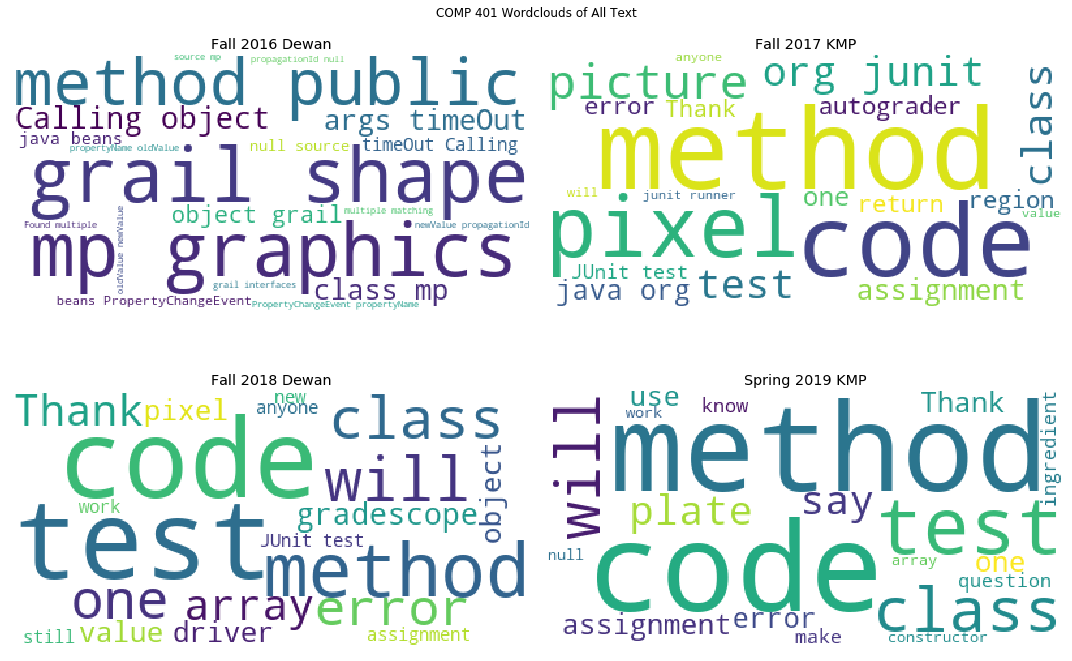

In [6]:
# Plot word clouds of all the currently completed 401 classes
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("COMP 401 Wordclouds of All Text")

ax = ax.flatten()
for i in range(0, 4):
    wordcloud = WordCloud(background_color="white", max_words=20, contour_width=3, contour_color='steelblue')
    wordcloud.generate(all_text[i])
    ax[i].imshow(wordcloud)
    ax[i].set_title(id_class_map[network_ids[i]])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.tight_layout()
plt.savefig('output/all_text_wordclouds')
plt.show()

### Takeaways:

# All of the word clouds are very similar, Dewan's 2016 class is the most complex 
# and has more technical words and a lot of stack traces 

# KMP's Spring 2019 section is the simplest, with people asking primarily about administrative things
# Dewan's Spring 2019 section is less technical and complicated than his 2016 section

# Does this mean that the professors are getting better at structuring their assignments over time? 
# Students could be better at reaching out about technical details in 
# office hours rather than posting about them in Piazza 

# Students have gotten better about looking for the answers themselves
# Office hours could have been expanded/improved

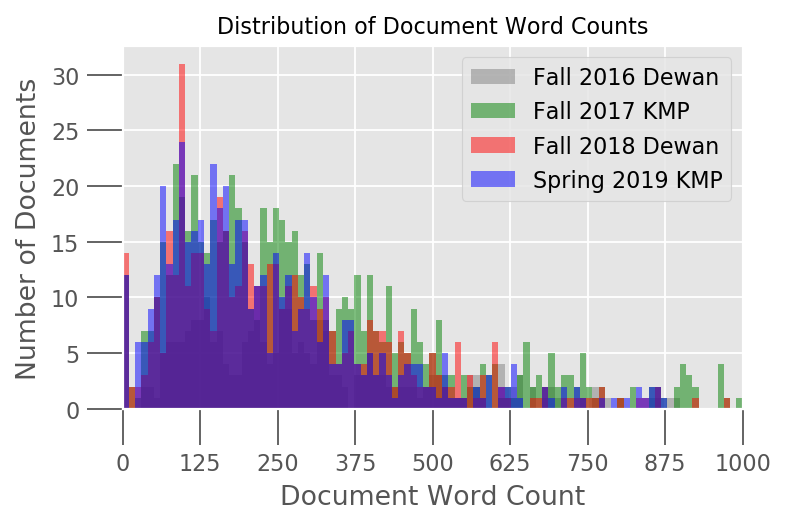

In [7]:
# Plot the distribution of word counts for all completed 401 classes that we have
bins = np.linspace(0, 1000, 100)
colors = ['gray', 'green', 'red', 'blue']

plt.figure(figsize=(5, 3), dpi=160)
for i in range(len(student_dfs)-1):
    plt.hist(student_dfs[i]['word_count'], bins, color=colors[i], alpha=.5, label=id_class_map[network_ids[i]])

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 1000, 9))

plt.legend(loc='upper right')
plt.title('Distribution of Document Word Counts', fontdict=dict(size=10))

plt.savefig('output/overlaid_word_counts')
plt.show()


### Takeways:

# All of the classes have the same skew
# Color theory is hard

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


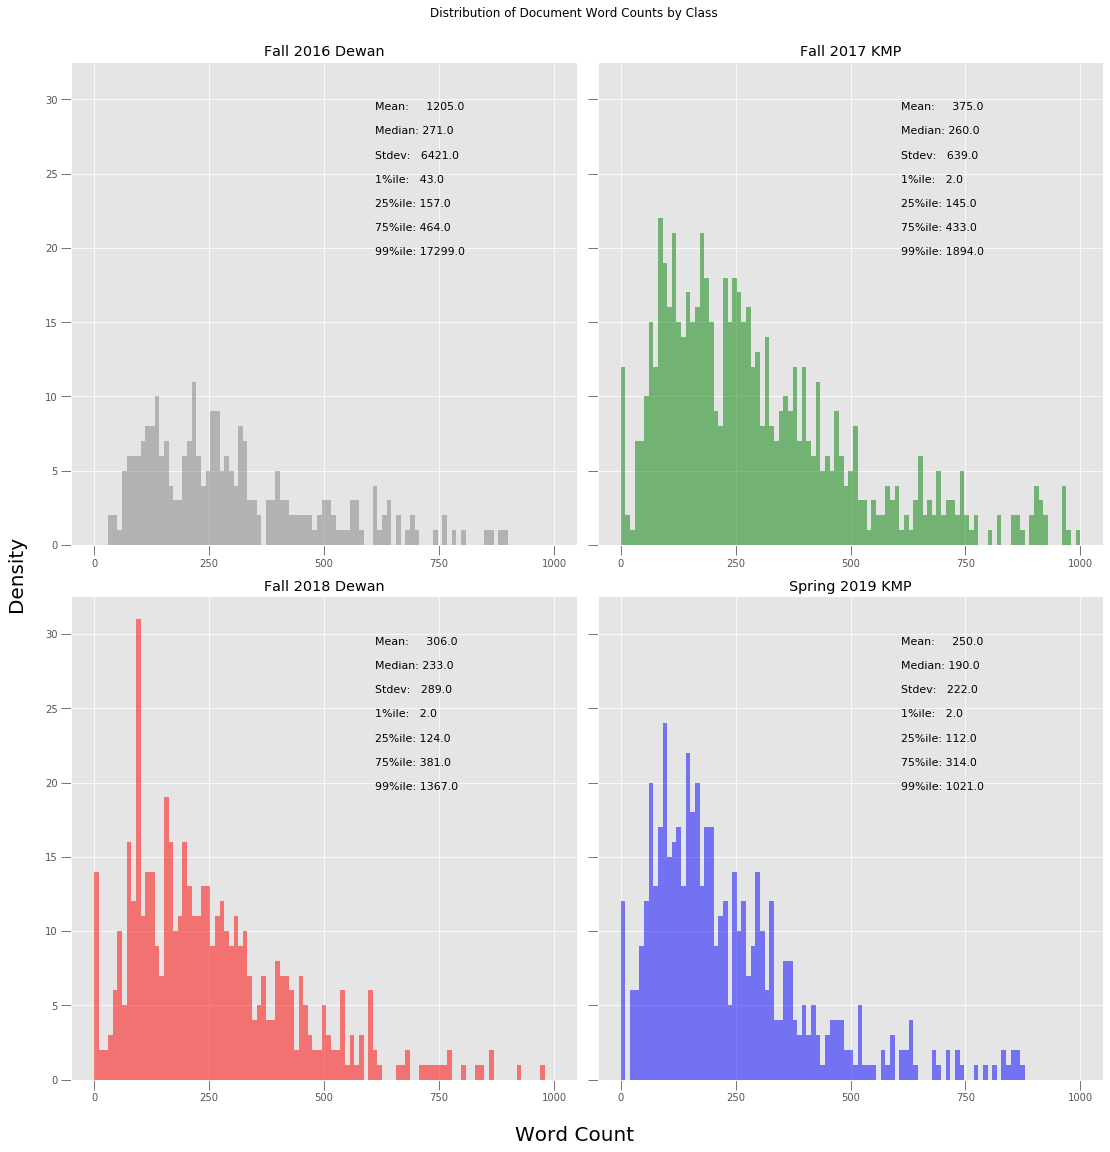

In [8]:
# Plot the distribution of word counts for each class  separately
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharey=True)
fig.suptitle("Distribution of Document Word Counts by Class", y=1.025)

axs = axs.flatten()
for i in range(len(student_dfs)-1):
    axs[i].hist(student_dfs[i]['word_count'], bins, color=colors[i], alpha=.5)
    axs[i].set_title(id_class_map[network_ids[i]])
    
    # Computation of Summary Statistics
    summary_stats = {}
    summary_stats['Mean'] = str(round(np.mean(student_dfs[i]['word_count'])))
    summary_stats['Median'] = str(round(np.median(student_dfs[i]['word_count'])))
    summary_stats['Stdev'] = str(round(np.std(student_dfs[i]['word_count'])))
    summary_stats['1%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.01)))
    summary_stats['25%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.25)))
    summary_stats['75%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.75)))
    summary_stats['99%ile'] = str(round(np.quantile(student_dfs[i]['word_count'], q=0.99)))

    starting_y = .90
    # get max length of the key and add diff as offset
    for k, v in summary_stats.items():
        axs[i].annotate(
            k +': ' + ''.join(' ' * (2*(6-len(k)))) + v,
            (.60, starting_y),
            textcoords='axes fraction',
            size=11)
        
        starting_y -= .05
    
    axs[i].tick_params(size=10)
    axs[i].set_xticks(np.linspace(0, 1000, 5))

fig.tight_layout()
fig.text(0.5, -.025, 'Word Count', ha='center', fontsize=20)
fig.text(-.025, 0.5, 'Density', va='center', rotation='vertical', fontsize=20)

plt.savefig('output/word_counts_by_class')
plt.show()

### Takeaways:

# All of the classes have around the same median word count. 

# However, Dewan's 2016 has both significantly higher mean and standard deviation, upon closer 
# inspection that is because of several posts with extremely high wordcount. This confirms the
# idea that people are just posting code/long stack traces. 

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


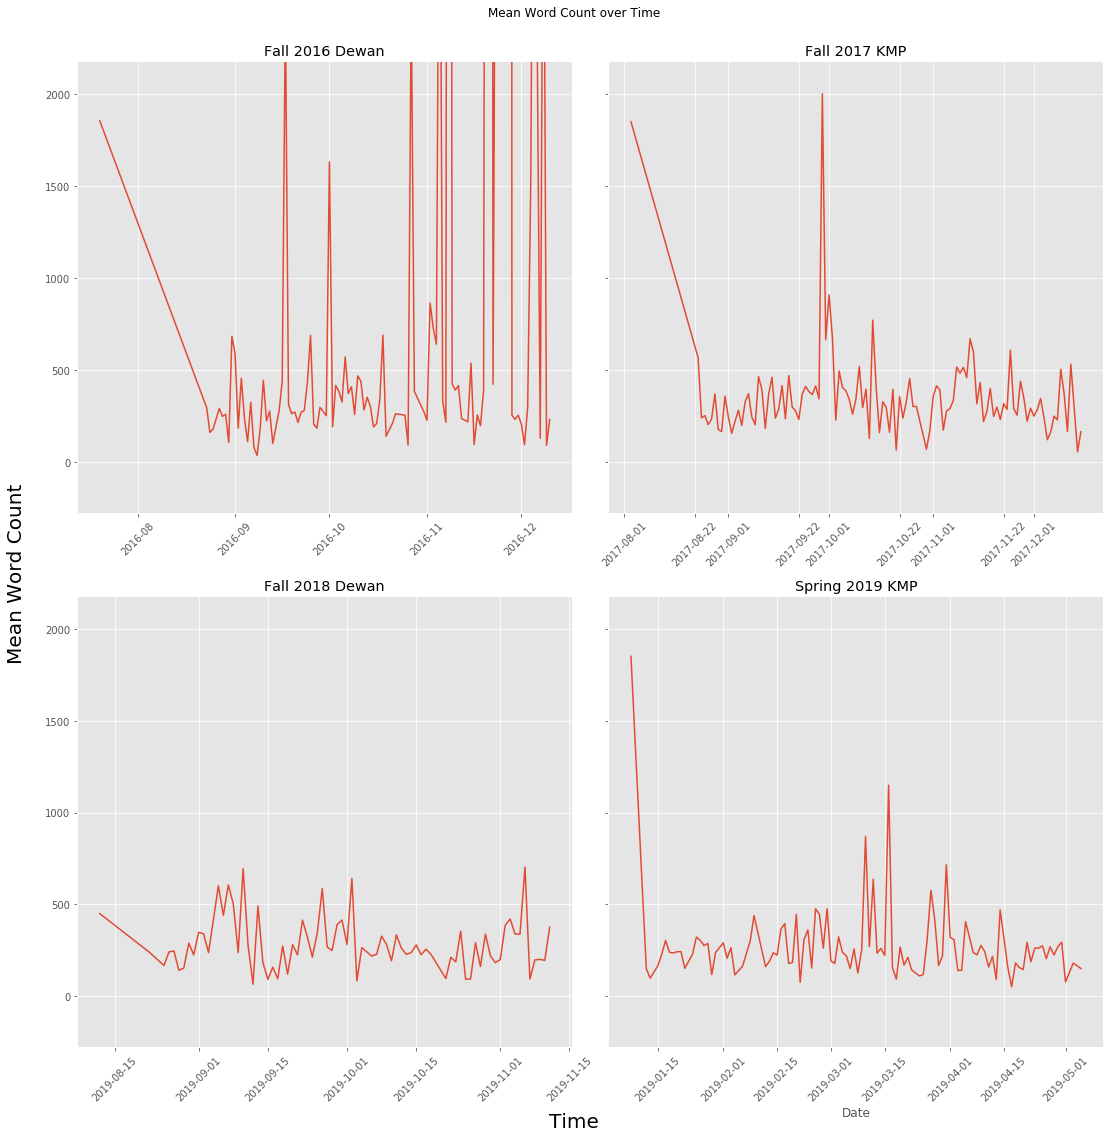

In [9]:
# Plotting mean word count over time
sorted_word_counts = [sorted_word_count(df) for df in student_dfs]
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
months = mdates.MonthLocator()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharex=False, sharey=True)
fig.suptitle("Mean Word Count over Time", y=1.025)

ax = ax.flatten()
for i in range(len(student_dfs)-1):
    wc = sorted_word_counts[i]
    
    y_min, y_max, stdev = min(wc['word_count']), max(wc['word_count']), np.std(wc['word_count'])
    ax[i].set_ylim([y_min - 1.5*stdev, y_max + 1.5*stdev])

    ax[i].plot(wc['created'], wc['word_count'])
    ax[i].set_title(id_class_map[network_ids[i]])
    ax[i].xaxis.set_minor_locator(months)

    plt.sca(ax[i])
    plt.xticks(rotation=45)

fig.tight_layout()
fig.text(0.5, -.0125, 'Time', ha='center', fontsize=20)
fig.text(-.025, 0.5, 'Mean Word Count', va='center', rotation='vertical', fontsize=20)

plt.xlabel("Date")
plt.savefig("output/word_counts_over_time")
plt.show()

### Takeways: 

# The idea of Dewan's 2016 class having more erratic word count is confirmed here.

# What do these large spikes represent? Likely exams, assignment due dates, and final exams.

# Comparing each of the professor's offering of the same class, it looks like over time the posts 
# of the different classes have become much less erratic.

In [10]:
# Combine all of the student question posts and the instructor posts into respective DataFrames
all_student_dfs = pd.DataFrame()
all_instructor_dfs = pd.DataFrame()

for i in range(0, len(dfs)):
    class_name = id_class_map[network_ids[i]]
    
    student_dfs[i].loc[:, 'class_name'] = class_name
    student_dfs[i].loc[:, 'user_id'] = student_dfs[i]['history'].map(lambda x: x[0]['uid'] if 'uid' in x[0].keys() else '')    
    
    instructor_dfs[i].loc[:, 'class_name'] = class_name
    instructor_dfs[i].loc[:, 'user_id'] = instructor_dfs[i]['history'].map(lambda x: x[0]['uid'] if 'uid' in x[0].keys() else '')    

    all_student_dfs = all_student_dfs.append(student_dfs[i])
    all_instructor_dfs = all_instructor_dfs.append(instructor_dfs[i])

/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lexokan/opt/anaconda3/envs/piazza/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


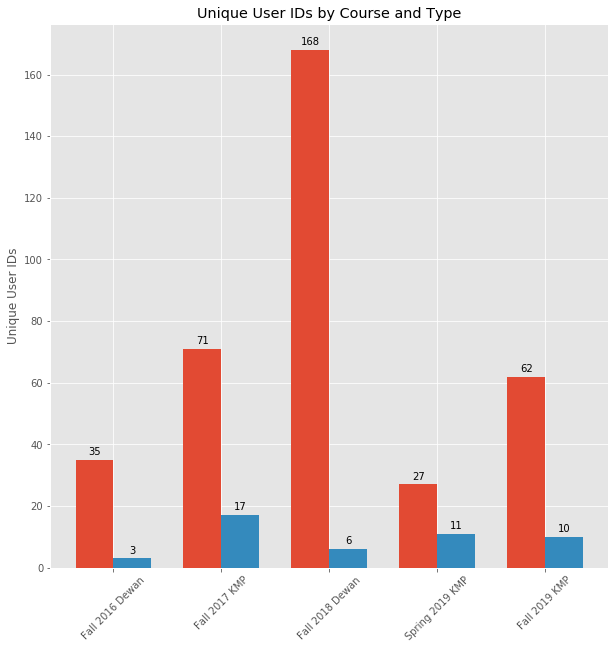

In [11]:
# Number of unique posters per class
unique_student_posters_by_class = all_student_dfs.groupby('class_name')['user_id'].nunique()
unique_instructor_posters_by_Class = all_instructor_dfs.groupby('class_name')['user_id'].nunique()

fig, ax = plt.subplots(figsize=(10, 10))

x = np.arange(len(dfs))
bar_width = .35

rect1 = ax.bar(x-bar_width/2, unique_student_posters_by_class, bar_width, label='Students')
rect2 = ax.bar(x+bar_width/2, unique_instructor_posters_by_Class, bar_width, label='Instructors')

# Citation: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)

ax.set_ylabel("Unique User IDs")
ax.set_xticks(x)
ax.set_xticklabels([id_class_map[network_ids[i]] for i in range(len(dfs))])

plt.xticks(rotation='45')
plt.title('Unique User IDs by Course and Type')
plt.savefig('output/unique_user_ids_by_course_and_type')
plt.show()          

### Takeaways

# Not really a clear correlation between the number of 
# unique student posters and the number of unique instructor posters

# Would be interesting to seee the number of unique student posters
# plotted against the number of overall instructor posts
                    

In [12]:
# Identifying frequent posters
all_student_dfs.groupby(['class_name', 'user_id'])['id'].count().reset_index(name='count').sort_values(by='count', ascending=False)
# all_student_dfs.groupby(['class_name', 'user_id'])[['class_name', 'user_id']].transform('count')

,class_name,user_id,count
35,Fall 2017 KMP,,453
301,Spring 2019 KMP,,419
0,Fall 2016 Dewan,,109
47,Fall 2017 KMP,is6wwuwth5d2tg,68
274,Fall 2019 KMP,,41
...,...,...,...
174,Fall 2018 Dewan,jqk5eqmp10s4ss,1
179,Fall 2018 Dewan,jqqpskscvw738v,1
180,Fall 2018 Dewan,jqqqb3q7lbh1b5,1
1,Fall 2016 Dewan,gd6v7134AUa,1


In [13]:
# Identifying popular posts and posters
all_student_dfs.sort_values(by='unique_views', ascending=False)

# student_dfs[0].groupby('user_id').mean()[['unique_views', 'wortd_count']].sort_values(by='unique_views', ascending=False)

,id,created,type,folders,tags,is_announcement,history,children,tag_good,is_student,no_answer,num_children,num_favorites,num_revisions,unique_views,subject,text,word_count,class_name,user_id
108,k2cmxtsswv256p,2019-10-30 02:02:50+00:00,note,[hw6],"[hw6, student]",0,"[{'anon': 'stud', 'uid': 'jzkkl0dmzkl5ld', 'su...","[{'anon': 'no', 'folders': [], 'data': None, '...","[{'role': 'student', 'name': 'Milen Patel', 'e...",True,NaN,1,2,1,324,A6 JUnit Tests,Here are JUnit tests I made for A6. They are ...,129,Fall 2018 Dewan,jzkkl0dmzkl5ld
98,k2hv6xu8ffx5s4,2019-11-02 17:52:43+00:00,question,[hw6],"[hw6, student]",0,"[{'anon': 'stud', 'uid': 'jlzzvaxu9ev6d', 'sub...","[{'folders': [], 'data': {'embed_links': []}, ...",[],True,0.0,1,2,1,272,Junit Tests,Can someone explain how to put the Junit test...,385,Fall 2018 Dewan,jlzzvaxu9ev6d
849,j6odt5u65vj2lh,2017-08-23 02:09:55+00:00,question,[assignment1],"[assignment1, student]",0,"[{'anon': 'no', 'uid': 'is7g7mjyno41k', 'subje...","[{'folders': [], 'data': {'embed_links': []}, ...","[{'role': 'student', 'name': 'Rachel', 'admin'...",True,0.0,1,0,2,262,A1 Jedi Example Solution,Given example: 5 5 10 10 10 25 125 5 Carrie...,2130,Fall 2017 KMP,is7g7mjyno41k
550,jqtmx4dynhh3oz,2019-01-12 15:37:54+00:00,question,[logistics],"[logistics, student]",0,"[{'anon': 'no', 'uid': 'is6fmv4jix229j', 'subj...","[{'folders': [], 'data': {'embed_links': []}, ...","[{'role': 'student', 'name': 'Jacob William Ha...",True,0.0,1,0,1,244,First Assignment Posting Date?,"So, the syllabus says that we should complete...",149,Spring 2019 KMP,is6fmv4jix229j
844,j6p9dagwfde5jt,2017-08-23 16:53:22+00:00,question,[assignment1],"[assignment1, student]",0,"[{'anon': 'no', 'uid': 'is6wwuwth5d2tg', 'subj...","[{'folders': [], 'data': {'embed_links': []}, ...",[],True,0.0,1,0,1,243,Importing Assignment 1 to Eclipse,"Hi Everyone, Sorry for all the questions. B...",260,Fall 2017 KMP,is6wwuwth5d2tg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,k0vip6roz786b4,2019-09-22 21:52:21+00:00,question,[hw3],"[hw3, student]",0,"[{'anon': 'no', 'uid': 'jzk5wwqdglc52o', 'subj...","[{'anon': 'no', 'folders': [], 'data': None, '...",[],True,0.0,1,0,1,13,Need an instructor to help me with github,Something has gone horribly wrong with my rep...,129,Fall 2018 Dewan,jzk5wwqdglc52o
381,k0vgzmnv3y4756,2019-09-22 21:04:29+00:00,question,[hw3],"[hw3, student]",0,"[{'anon': 'no', 'uid': 'jqphp3jfz0z652', 'subj...","[{'folders': [], 'data': {'embed_links': []}, ...",[],True,0.0,1,0,1,12,Trouble with field array and output,"Hello, I was able to get past errors involvin...",506,Fall 2018 Dewan,jqphp3jfz0z652
424,k0rfvmczkv91pr,2019-09-20 01:22:18+00:00,note,[hw3],"[hw3, student]",0,"[{'anon': 'no', 'uid': 'jl2n929zzq2ts', 'subje...",[],[],True,NaN,0,0,1,12,I don&#39;t think the auto grader is working,"I just finished a3 adept, and wanted to uploa...",189,Fall 2018 Dewan,jl2n929zzq2ts
326,k12kk9fyfnm3ic,2019-09-27 20:18:54+00:00,note,[hw4],"[hw4, student]",0,"[{'anon': 'no', 'uid': 'jl2n929zzq2ts', 'subje...",[],[],True,NaN,0,0,1,11,Figured out Adept constructor problem I came t...,I was having a problem with Adept where JUnit...,472,Fall 2018 Dewan,jl2n929zzq2ts


In [14]:
# TODO: Thread responsiveness 
# TODO: Filter questions 
# TODO: Sort by homeworks
# Num Children as proxy for responsiveness (FIX, within transform_posts

In [15]:
# Add on the post answers to each of the student and instructor posts (FIX)
# https://stackoverflow.com/questions/6027558/flatten-nested-dictionaries-compressing-keys
for i in range(len(dfs)):
    fp = dfs[i][16:-2]

    student_df_with_answer = (student_dfs[i]
                             .query("type=='question'"))

    instructor_df_with_answer = (instructor_dfs[i]
                             .query("type=='note'"))
    
    student_ans = []
    for j in range(len(student_df_with_answer['children'])):
        ans = student_df_with_answer['children'].iloc[j]        
        if ans:
            student_ans.append(list(next_content(ans[0])))
        else:
            student_ans.append([''])        
        
    instructor_ans = []
    for j in range(len(instructor_df_with_answer['children'])):
        ans = instructor_df_with_answer['children'].iloc[j]
        if ans:
            instructor_ans.append(list(next_content(ans[0])))
        else:
            instructor_ans.append([''])
            
    student_df_with_answer.loc[:, 'answer'] = student_ans
    instructor_df_with_answer.loc[:, 'answer'] = instructor_ans
                
    with open(f'data/answers/{fp}_student.p', 'wb') as f:
        pickle.dump(student_df_with_answer, f)
    
    with open(f'data/answers/{fp}_instructor.p', 'wb') as f:
        pickle.dump(instructor_df_with_answer, f)

In [16]:
# TODO: move all pipeline stuff to transform_posts.py

In [17]:
# TODO: Look at instructor only posts as well

In [18]:
# TODO: Look at class syllabi for timing of assignments and midterms to correlate with spikes in different plots

In [19]:
# TODO: Bar chart of top words for topics

In [20]:
# TODO: Types of things that students are looking to answer (conceptual vs. applied)
# TODO: Where is the most confusion, what are students potentially more afraid to ask about? 

In [21]:
# TODO: Question or Answer? 
# TOOO: Num votes/ good question 

In [22]:
# TODO: Simple summary stats with pandas pipeline

In [23]:
# TODO: t_SNE

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

## Questions

Are students asking conceptual or applied questions?
Which topics are more prevalent? Where is the most confusion?
    - Topic Modeling
    - Run the same topic model over different intervals of time
What do in-person interactions not already tell us? 
What are areas that need attention in student understanding? 
    - Concrete evidence of topics where students are struggling
Probably don't look at response time
What are people afraid of asking about? (Anonymous posts from students)
Data:
    - Timestamp
    - Userid (student or instructor, throw out announcements)
    - Question or answer? 
    - Votes (good question)
    - Question Text